In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
from smote import smote_binary, smote_multiclass
from skorch import NeuralNetClassifier
from performance_report import performance_report
from sklearn import metrics

In [47]:
# setup 
device = torch.device('cpu')
bucket = 'm-team1'
role = get_execution_role()    
file = 'all_disorders_remove_std.csv'
data_loc = 's3://{}/{}'.format(bucket, file)

In [48]:
# reading CSV and separating data into train and test sets 

df = pd.read_csv(data_loc).iloc[: , 1:]

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

augment = True

if augment:
    df_train = pd.concat([y_train, X_train], axis=1)
    df_train = smote_multiclass(df_train, {0:1000, 1:1000, 2:1000, 3:1000}, one_hot_encoded=False)
    X_train = df_train.iloc[:,1:]
    y_train = df_train.iloc[:,0]

    X = torch.tensor(pd.concat([X_train, X_test]).values.astype(np.float32))
    y = torch.tensor(pd.concat([y_train, y_test]).values.astype(np.long))
    
else:
    X = torch.tensor(X.values.astype(np.float32))
    y = torch.tensor(y.values.astype(np.long))   
    
print(X.size())
print(y.size())

X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.long))
y_test = torch.tensor(y_test.values.astype(np.long))

torch.Size([5337, 11])
torch.Size([5337])


In [49]:
class Model(nn.Module):
    def __init__(self, input_dim=11):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [50]:
net = NeuralNetClassifier(
    Model,
    max_epochs=15,
    lr=0.001,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
)

net.fit(X_train, y_train)

y_pred = net.predict(X_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3025       0.4750        1.2350  0.0713
      2        1.1950       0.6913        1.1459  0.0708
      3        1.1000       0.7325        1.0590  0.0709
      4        1.0335       0.7738        1.0087  0.0707
      5        0.9934       0.7875        0.9787  0.0702
      6        0.9700       0.8050        0.9594  0.0711
      7        0.9543       0.8137        0.9465  0.0709
      8        0.9430       0.8100        0.9385  0.0710
      9        0.9345       0.8125        0.9327  0.0716
     10        0.9286       0.8163        0.9286  0.0703
     11        0.9241       0.8200        0.9251  0.0711
     12        0.9194       0.8187        0.9226  0.0701
     13        0.9153       0.8237        0.9187  0.0728
     14        0.9115       0.8300        0.9156  0.0718
     15        0.9053       0.8400        0.9115  0.0704


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3062       0.5921        1.2546  0.0772
      2        1.2155       0.8079        1.1656  0.0775
      3        1.1024       0.8034        1.0382  0.0771
      4        0.9991       0.8056        0.9695  0.0778
      5        0.9560       0.8067        0.9481  0.0776
      6        0.9430       0.8090        0.9408  0.0774
      7        0.9380       0.8090        0.9360  0.0771
      8        0.9347       0.8090        0.9327  0.0772
      9        0.9323       0.8180        0.9299  0.0777
     10        0.9295       0.8169        0.9278  0.0777
     11        0.9259       0.8124        0.9262  0.0778
     12        0.9229       0.8202        0.9238  0.0772
     13        0.9187       0.8236        0.9220  0.0777
     14        0.9124       0.8360        0.9151  0.0772
     15        0.9049       0.8382        0.9111  0.0765
  epoch    train_loss    valid_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


      3        1.1787       0.7899        1.1195  0.0784
      4        1.0659       0.7978        1.0108  0.0774
      5        0.9845       0.8000        0.9635  0.0776
      6        0.9558       0.8022        0.9503  0.0771
      7        0.9475       0.8034        0.9458  0.0768
      8        0.9443       0.8034        0.9437  0.0773
      9        0.9426       0.8034        0.9426  0.0766
     10        0.9417       0.8034        0.9420  0.0780
     11        0.9411       0.8034        0.9416  0.0776
     12        0.9408       0.8034        0.9413  0.0776
     13        0.9404       0.8034        0.9411  0.0780
     14        0.9402       0.8034        0.9409  0.0782
     15        0.9399       0.8034        0.9407  0.0775
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2980       0.5360        1.2633  0.0779
      2        1.2291       0.7966        1.1851  0.0815


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


      3        1.1253       0.7978        1.0605  0.0807
      4        1.0187       0.8011        0.9800  0.0771
      5        0.9650       0.8034        0.9536  0.0770
      6        0.9485       0.8045        0.9457  0.0776
      7        0.9432       0.8045        0.9425  0.0781
      8        0.9410       0.8045        0.9408  0.0781
      9        0.9396       0.8045        0.9395  0.0774
     10        0.9383       0.8045        0.9376  0.0770
     11        0.9367       0.8101        0.9347  0.0778
     12        0.9336       0.8124        0.9312  0.0777
     13        0.9313       0.8146        0.9293  0.0772
     14        0.9296       0.8146        0.9276  0.0768
     15        0.9276       0.8146        0.9263  0.0773
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2972       0.7528        1.2566  0.0760
      2        1.2189       0.8034        1.1728  0.0773


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


      3        1.1045       0.8011        1.0349  0.0770
      4        0.9926       0.8034        0.9655  0.0768
      5        0.9551       0.8045        0.9496  0.0768
      6        0.9461       0.8045        0.9446  0.0770
      7        0.9425       0.8045        0.9421  0.0767
      8        0.9403       0.8045        0.9403  0.0766
      9        0.9380       0.8056        0.9383  0.0763
     10        0.9355       0.8101        0.9361  0.0774
     11        0.9327       0.8079        0.9330  0.0787
     12        0.9287       0.8101        0.9303  0.0828
     13        0.9254       0.8101        0.9270  0.0825
     14        0.9206       0.8225        0.9244  0.0766
     15        0.9136       0.8315        0.9187  0.0777
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3164       0.6876        1.2534  0.0764
      2        1.2189       0.8056        1.1745  0.0793


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


      3        1.1180       0.8034        1.0551  0.0783
      4        1.0122       0.8056        0.9770  0.0775
      5        0.9627       0.8056        0.9528  0.0775
      6        0.9483       0.8056        0.9452  0.0774
      7        0.9435       0.8056        0.9424  0.0780
      8        0.9411       0.8056        0.9407  0.0771
      9        0.9396       0.8056        0.9394  0.0775
     10        0.9384       0.8056        0.9377  0.0774
     11        0.9370       0.8079        0.9361  0.0776
     12        0.9358       0.8112        0.9345  0.0771
     13        0.9344       0.8124        0.9330  0.0777
     14        0.9314       0.8112        0.9314  0.0769
     15        0.9297       0.8124        0.9296  0.0797
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3030       0.4978        1.2575  0.0778
      2        1.2145       0.8011        1.1610  0.0774


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


      3        1.1012       0.8011        1.0387  0.0769
      4        0.9988       0.8045        0.9662  0.0770
      5        0.9560       0.8045        0.9482  0.0774
      6        0.9446       0.8045        0.9418  0.0938
      7        0.9397       0.8079        0.9371  0.0934
      8        0.9363       0.8124        0.9336  0.0799
      9        0.9336       0.8157        0.9312  0.0770
     10        0.9309       0.8146        0.9284  0.0768
     11        0.9274       0.8202        0.9254  0.0772
     12        0.9235       0.8292        0.9231  0.0816
     13        0.9178       0.8315        0.9163  0.0766
     14        0.9104       0.8427        0.9086  0.0767
     15        0.9019       0.8472        0.9021  0.0765


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


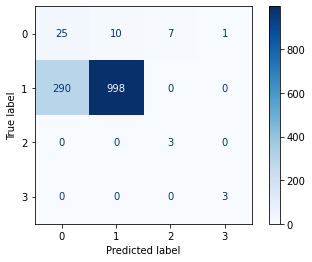

In [51]:
performance_report(net, X, y, X_test, y_test, y_pred, "multiclass_remove_1000")

In [52]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.58      0.08      0.14       315
           1       0.77      0.99      0.87      1008
           2       1.00      0.30      0.46        10
           3       1.00      0.75      0.86         4

    accuracy                           0.77      1337
   macro avg       0.84      0.53      0.58      1337
weighted avg       0.73      0.77      0.69      1337

